📂 成功加载数据: mcm26Train-B-Data/hall_calls.csv
🧹 已清空旧输出文件夹: MCM_Simulation_Results
📂 新输出目录已就绪: c:\Users\ROG\Desktop\MCM_B\MCM2026\MCM_Simulation_Results

🎲 [图1] 单日详情分析: 2025-11-06 (工作日)
💾 已保存: Task1_Detail_2025-11-06.svg


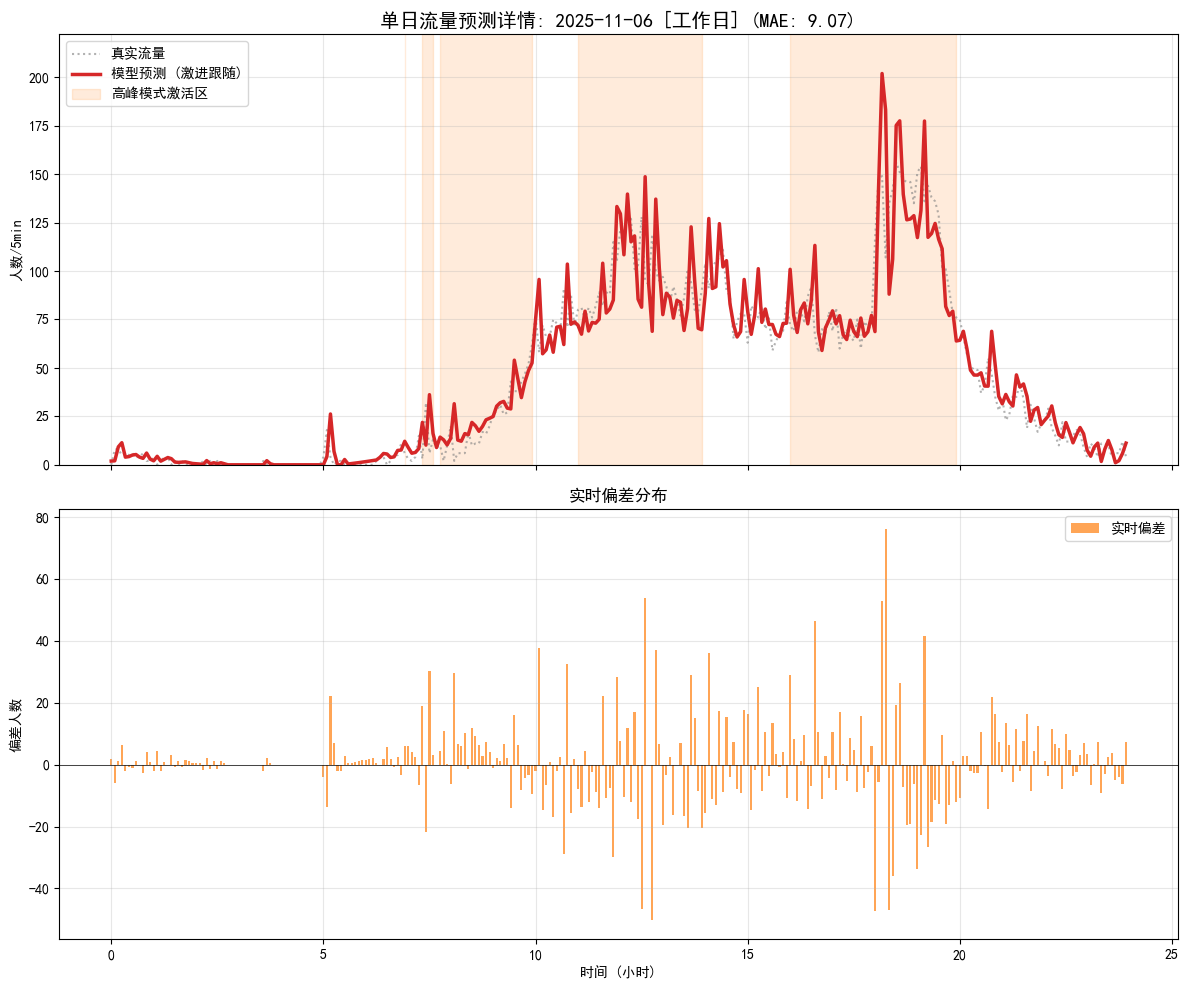


📊 [图2] 全月趋势分析正在进行...
✅ 月度平均误差 (Overall MAE): 6.70
💾 已保存: Task1_Monthly_Trend.svg


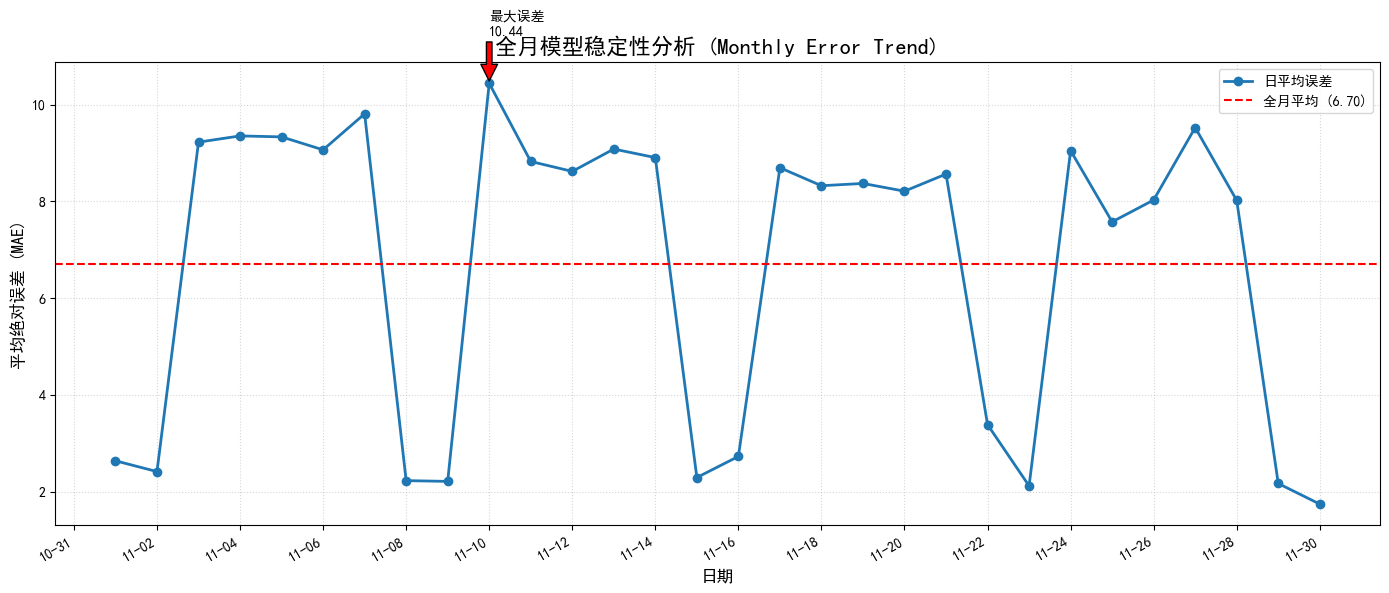

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import os
import shutil

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 🔮 模块一：Task 1 趋势感知预测器 (激进版)
# ==========================================
class DemandPredictor:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.weekday_model = None
        self.weekend_model = None
        self._train_history_models()

    def _train_history_models(self):
        df = self.raw_data.copy()
        df['Time'] = pd.to_datetime(df['Time'])
        df['DayOfWeek'] = df['Time'].dt.dayofweek 
        
        weekday_df = df[df['DayOfWeek'] < 5]
        weekend_df = df[df['DayOfWeek'] >= 5]
        
        self.weekday_model = self._fit_poly(weekday_df)
        self.weekend_model = self._fit_poly(weekend_df)

    def _fit_poly(self, df):
        if len(df) == 0: return lambda x: 0
        traffic = df.set_index('Time').resample('5min').size().reset_index()
        traffic.columns = ['Time', 'Count']
        traffic['minutes'] = traffic['Time'].dt.hour * 60 + traffic['Time'].dt.minute
        x = traffic['minutes'].values
        y = traffic['Count'].values
        
        if len(x) > 10:
            coeffs = np.polyfit(x, y, deg=6)
            return np.poly1d(coeffs)
        else:
            return lambda x: 0

    def get_realtime_trend_data(self, current_seconds, day_specific_lookup, is_weekend, window=15):
        current_minutes = (current_seconds // 60) % 1440
        x_local = []
        y_local = []
        
        for m in range(current_minutes - window, current_minutes, 5):
            val = day_specific_lookup.get(m, 0)
            x_local.append(m)
            y_local.append(val)
            
        if len(x_local) < 2: return 0, 0 

        coeffs = np.polyfit(x_local, y_local, deg=1)
        slope = coeffs[0] 
        func = np.poly1d(coeffs)
        pred_realtime = max(0, func(current_minutes))
        
        if is_weekend:
            pred_history = max(0, self.weekend_model(current_minutes))
        else:
            pred_history = max(0, self.weekday_model(current_minutes))
        
        # 激进跟随策略
        alpha = 0.4 
        if pred_realtime > pred_history:
            alpha = 0.8
        if slope > 1.2:
            pred_realtime *= 1.15
            alpha = max(alpha, 0.9)
            
        final_pred = (1 - alpha) * pred_history + alpha * pred_realtime
        return final_pred, slope

# ==========================================
# 🧠 模块二：Task 2 智能模式选择器
# ==========================================
class ModeSelector:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.valid_windows = {
            'UP_PEAK': (6, 10), 'LUNCH': (11, 14), 'DOWN_PEAK': (16, 20)
        }
        self.thresholds = {}
        self._learn_activation_thresholds()

    def _learn_activation_thresholds(self):
        temp = self.raw_data.copy()
        temp['Time'] = pd.to_datetime(temp['Time'])
        traffic = temp.set_index('Time').resample('5min').size()
        
        if len(traffic) > 0:
            base_line = traffic.quantile(0.55)
            alert_line = traffic.quantile(0.40)
        else:
            base_line = 10
            alert_line = 5
            
        self.thresholds['HARD_TRIGGER'] = max(8, base_line)
        self.thresholds['SOFT_TRIGGER'] = max(5, alert_line)
        self.thresholds['TREND_SLOPE'] = 1.5

    def get_mode(self, current_seconds, pred_demand, trend_slope):
        hour = (current_seconds // 3600) % 24
        possible_mode = 'OFF_PEAK'
        for mode, (start, end) in self.valid_windows.items():
            if start <= hour < end:
                possible_mode = mode
                break
        
        if possible_mode == 'OFF_PEAK': return 'OFF_PEAK'

        if pred_demand >= self.thresholds['HARD_TRIGGER']:
            return possible_mode
        elif (pred_demand >= self.thresholds['SOFT_TRIGGER']) and (trend_slope >= self.thresholds['TREND_SLOPE']):
            return possible_mode
            
        return 'OFF_PEAK'

# ==========================================
# ⚙️ 模块三：Task 3 动态群控策略 (核心算法)
# ==========================================
# 权重配置 [距离, 方向, 载重, 任务数, 势能, 拥挤排斥]
MODE_WEIGHTS = {
    'UP_PEAK':   [1.0, 15.0, 1.0, 1.0, 20.0, 10.0],
    'DOWN_PEAK': [1.0, 10.0, 1.0, 2.0, 5.0,  30.0],
    'LUNCH':     [2.0, 2.0,  0.5, 0.5, 2.0,  5.0],  
    'OFF_PEAK':  [1.0, 1.0,  10.0, 1.0, 0.0, 0.0]   
}

def calculate_dynamic_cost(elev, req_floor, mode, pred_demand, slope, all_elevators):
    w1, w2, w3, w4, w5, w6 = MODE_WEIGHTS[mode]
    
    # 1. 基础物理代价
    dist_cost = abs(elev.current_floor - req_floor)
    load_cost = elev.load_count
    task_cost = len(elev.stops)
    
    # 2. 方向惩罚
    dir_cost = 0
    if elev.state != 'IDLE':
        if (elev.direction == 1 and req_floor < elev.current_floor) or \
           (elev.direction == -1 and req_floor > elev.current_floor):
            dir_cost = 20 
            
    # 3. 趋势增强型势能场
    potential_cost = 0
    trend_factor = 1.0 + max(0, slope * 0.5) 
    
    if mode == 'UP_PEAK':
        potential_cost = (elev.current_floor * pred_demand) * trend_factor
    elif mode == 'DOWN_PEAK':
        potential_cost = ((30 - elev.current_floor) * (pred_demand * 0.1)) * trend_factor

    # 4. 空间排斥
    bunching_cost = 0
    if mode != 'OFF_PEAK':
        for teammate in all_elevators:
            if teammate.id == elev.id: continue
            dist_to_mate = abs(teammate.current_floor - elev.current_floor)
            if dist_to_mate < 3 and teammate.direction == elev.direction:
                bunching_cost += (10.0 / (dist_to_mate + 1))

    total_cost = (w1 * dist_cost) + (w2 * dir_cost) + (w3 * load_cost) + \
                 (w4 * task_cost) + (w5 * potential_cost) + (w6 * bunching_cost)
                 
    return total_cost

# ==========================================
# 🏗️ 仿真对象：智能电梯 (带轨迹记录)
# ==========================================
class SmartElevator:
    def __init__(self, id):
        self.id = id
        self.current_floor = 1
        self.direction = 0 
        self.state = 'IDLE'
        self.stops = set() 
        self.passengers = [] 
        self.total_trips = 0 
        self.history_pos = [] # 记录轨迹

    @property
    def load_count(self):
        return len(self.passengers)

    def move(self):
        self.history_pos.append(self.current_floor) # 记录位置
        
        if self.state == 'IDLE': return
        self.current_floor += self.direction
        
        if self.current_floor in self.stops:
            self.stops.remove(self.current_floor)
            self.passengers = [p for p in self.passengers if p['dest'] != self.current_floor]
            self.total_trips += 1 
            
        if not self.stops:
            self.state = 'IDLE'
            self.direction = 0
        elif max(self.stops, default=0) > self.current_floor:
            self.direction = 1
        elif min(self.stops, default=99) < self.current_floor:
            self.direction = -1

# ==========================================
# 🎮 仿真总控中心
# ==========================================
class SimulationController:
    def __init__(self, data_path):
        try:
            self.full_df = pd.read_csv(data_path)
        except:
            self.full_df = pd.read_csv(data_path, encoding='gbk')
        self.full_df['Time'] = pd.to_datetime(self.full_df['Time'])
        
        # 初始化模块
        self.predictor = DemandPredictor(self.full_df)
        self.mode_selector = ModeSelector(self.full_df)
        self.elevators = [SmartElevator(i) for i in range(1, 9)] # 8部电梯

        # 文件夹管理
        self.output_dir = 'MCM_Simulation_Results' 
        self._initialize_output_folder()

    def _initialize_output_folder(self):
        if os.path.exists(self.output_dir):
            try:
                shutil.rmtree(self.output_dir)
                print(f"🧹 已清空旧输出文件夹: {self.output_dir}")
            except: pass
        os.makedirs(self.output_dir, exist_ok=True)
        print(f"📂 新输出目录已就绪: {os.path.abspath(self.output_dir)}")

    def run_random_day_simulation(self):
        """📊 Task 1 & 2: 单日详情分析 (预测+模式)"""
        unique_dates = self.full_df['Time'].dt.date.unique()
        if len(unique_dates) == 0: return
        selected_date = random.choice(unique_dates)
        
        pd_date = pd.to_datetime(selected_date)
        is_weekend = pd_date.dayofweek >= 5
        day_type = "周末" if is_weekend else "工作日"
        
        print(f"\n🎲 [图1] 单日详情分析: {selected_date} ({day_type})")
        
        day_df = self.full_df[self.full_df['Time'].dt.date == selected_date].copy()
        day_lookup = day_df.set_index('Time').resample('5min').size()
        day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
        
        time_axis = []
        actual_curve = []
        pred_curve = []
        errors = []
        mode_flags = []
        
        for t_min in range(0, 1440, 5): 
            t_seconds = t_min * 60
            pred_val, slope = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
            mode = self.mode_selector.get_mode(t_seconds, pred_val, slope)
            actual_val = day_lookup_dict.get(t_min, 0)
            
            time_axis.append(t_min / 60.0)
            actual_curve.append(actual_val)
            pred_curve.append(pred_val)
            errors.append(pred_val - actual_val)
            mode_flags.append(1 if mode != 'OFF_PEAK' else 0)

        mae = np.mean(np.abs(errors))
        self._plot_day_detail(selected_date, time_axis, actual_curve, pred_curve, errors, mae, day_type, mode_flags)

    def run_full_month_evaluation(self):
        """📊 Task 1: 全月误差趋势分析"""
        print("\n📊 [图2] 全月趋势分析正在进行...")
        unique_dates = sorted(self.full_df['Time'].dt.date.unique())
        date_list, mae_list = [], []
        
        for date in unique_dates:
            pd_date = pd.to_datetime(date)
            is_weekend = pd_date.dayofweek >= 5
            day_df = self.full_df[self.full_df['Time'].dt.date == date]
            day_lookup = day_df.set_index('Time').resample('5min').size()
            day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
            
            daily_errors = []
            for t_min in range(0, 1440, 5):
                t_seconds = t_min * 60
                pred_val, _ = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
                actual_val = day_lookup_dict.get(t_min, 0)
                daily_errors.append(abs(pred_val - actual_val))
            
            mae_list.append(np.mean(daily_errors))
            date_list.append(date)
            
        self._plot_monthly_trend(date_list, mae_list, np.mean(mae_list))

    def run_task3_evaluation(self):
        """📊 Task 3: 群控调度轨迹仿真"""
        print("\n🚀 [图3] Task 3 深度仿真 (早高峰群控演示)...")
        # 选一个工作日进行演示
        unique_dates = self.full_df['Time'].dt.date.unique()
        selected_date = random.choice(unique_dates) # 这里简化处理，随机选一天
        
        day_df = self.full_df[self.full_df['Time'].dt.date == selected_date].copy()
        min_time = pd.to_datetime(day_df['Time']).min()
        day_df['Seconds'] = (pd.to_datetime(day_df['Time']) - min_time).dt.total_seconds()
        request_queue = day_df.sort_values('Seconds').to_dict('records')
        
        day_lookup = day_df.set_index('Time').resample('5min').size()
        day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
        
        # 跑最忙的2小时 (07:00-09:00)
        start_hour = 7
        duration = 7200
        start_offset = start_hour * 3600
        req_idx = 0
        
        for t in range(duration):
            abs_time = start_offset + t
            pred_val, slope = self.predictor.get_realtime_trend_data(abs_time, day_lookup_dict, False) # 假定工作日逻辑
            mode = self.mode_selector.get_mode(abs_time, pred_val, slope)
            
            # 处理请求
            while req_idx < len(request_queue) and request_queue[req_idx]['Seconds'] <= abs_time:
                req = request_queue[req_idx]
                req_idx += 1
                
                best_elev = None
                min_cost = float('inf')
                for elev in self.elevators:
                    cost = calculate_dynamic_cost(elev, req['Floor'], mode, pred_val, slope, self.elevators)
                    if cost < min_cost:
                        min_cost = cost
                        best_elev = elev
                
                if best_elev:
                    best_elev.stops.add(req['Floor'])
                    dest = 30 if mode == 'UP_PEAK' else 1
                    best_elev.passengers.append({'dest': dest})
                    best_elev.stops.add(dest)
                    if best_elev.state == 'IDLE':
                        best_elev.state = 'MOVING'
                        best_elev.direction = 1 if req['Floor'] > best_elev.current_floor else -1
            
            # 移动电梯
            for elev in self.elevators:
                elev.move()
                
        self._plot_elevator_trajectory(duration)

    # --- 🎨 绘图函数区 ---
    
    def _plot_day_detail(self, date, x, y_actual, y_pred, errors, mae, day_type, modes):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        ax1.plot(x, y_actual, label='真实流量', color='gray', linestyle=':', alpha=0.6)
        ax1.plot(x, y_pred, label='模型预测', color='#d62728', linewidth=2.5)
        ax1.fill_between(x, 0, max(max(y_actual), max(y_pred))*1.2, where=modes, color='#ff7f0e', alpha=0.15, label='高峰模式')
        ax1.set_title(f'单日流量预测详情: {date} [{day_type}] (MAE: {mae:.2f})', fontsize=14)
        ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(max(y_actual), max(y_pred)) * 1.1)
        
        ax2.bar(x, errors, color='#ff7f0e', alpha=0.7, width=0.05, label='实时偏差')
        ax2.axhline(0, color='black', linewidth=0.5)
        ax2.set_xlabel('时间 (小时)'); ax2.set_ylabel('偏差人数')
        ax2.legend(); ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f'Task1_Detail_{date}.svg'), format='svg')
        plt.savefig(os.path.join(self.output_dir, f'Task1_Detail_{date}.pdf'), format='pdf')
        plt.show()

    def _plot_monthly_trend(self, dates, maes, avg_line):
        plt.figure(figsize=(14, 6))
        plt.plot(dates, maes, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
        plt.axhline(y=avg_line, color='red', linestyle='--', label=f'全月平均 ({avg_line:.2f})')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.gcf().autofmt_xdate()
        plt.title('全月模型稳定性分析', fontsize=16)
        plt.legend(); plt.grid(True, linestyle=':', alpha=0.5); plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'Task1_Monthly_Trend.svg'), format='svg')
        plt.savefig(os.path.join(self.output_dir, 'Task1_Monthly_Trend.pdf'), format='pdf')
        plt.show()

    def _plot_elevator_trajectory(self, duration):
        plt.figure(figsize=(15, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, 8))
        for i, elev in enumerate(self.elevators):
            plt.plot(range(duration), elev.history_pos, label=f'Elevator {i+1}', color=colors[i], alpha=0.8)
        plt.title('Task 3 群控调度验证: 电梯运行时空轨迹', fontsize=16)
        plt.xlabel('仿真时间 (秒)'); plt.ylabel('楼层')
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left'); plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'Task3_Trajectory.svg'), format='svg')
        plt.savefig(os.path.join(self.output_dir, 'Task3_Trajectory.pdf'), format='pdf')
        plt.show()

# ==========================================
# ▶️ 执行区域
# ==========================================
if __name__ == "__main__":
    possible_paths = [
        r'mcm26Train-B-Data/hall_calls.csv',
        r'MCM2026/mcm26Train-B-Data/hall_calls.csv',
        r'hall_calls.csv'
    ]
    data_path = None
    for p in possible_paths:
        if os.path.exists(p):
            data_path = p
            break
            
    if data_path:
        print(f"📂 成功加载数据: {data_path}")
        sim = SimulationController(data_path)
        sim.run_random_day_simulation() # Task 1 & 2
        sim.run_full_month_evaluation() # Task 1 Stability
        sim.run_task3_evaluation()      # Task 3
    else:
        print("❌ 找不到文件 hall_calls.csv")